In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42553")
client

<Client: 'tcp://127.0.0.1:42553' processes=10 threads=50, memory=196.73 GiB>

In [9]:
client.restart()

<Client: 'tcp://127.0.0.1:42553' processes=3 threads=15, memory=59.02 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

$$\epsilon_K = \frac{1}{C_\Psi}\int_{\kappa>k} \mathcal{R}\left[
\tilde{\boldsymbol{u}'}^*\cdot\widetilde{\boldsymbol{v}\cdot\nabla\boldsymbol{u}'} 
+ \widetilde{\overline{u'\boldsymbol{v}'}}^*\cdot\widetilde{\nabla\overline{u}} + \widetilde{\overline{v'\boldsymbol{v}'}}^*\cdot\widetilde{\nabla\overline{v}} + \tilde{\overline{u}}^*\widetilde{\nabla\cdot\overline{\boldsymbol{v}' u'}} + \tilde{\overline{v}}^*\widetilde{\nabla\cdot\overline{\boldsymbol{v}' v'}}
\right] x_0^2\kappa\, d\kappa$$

# Wavelet

In [16]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

ng = 2

yy = yystart

for reg in range(len(xs)-5):
# for reg in np.array([0,1,3,4,5], dtype=int):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+2]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:
            if itime == mtimes[0]:
                dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                           % (year,len(nmembs),itime))
                                  ).isel(time=0
                                        ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                              XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                             )
            else:
                dsb = xr.concat([dsb, xr.open_zarr(op.join(tdgs,
                                                        '5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                                  % (year,len(nmembs),itime))
                                                         ).isel(time=0
                                                 ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                       YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                       XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                                       XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                                      )
                                ], dim='time')

        for nmemb in nmembs:
            if nmemb == 0:
                ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=mtimes, 
                                        ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                              XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                             )
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=mtimes, 
                                                   ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                                         XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                                        )
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)
        dsb.coords['time'] = ds.time
#         print(dsb,ds)

        grid = Grid(ds, periodic=[])
            
        u = ds.UVEL.where(ds.maskW!=0.)
        v = ds.VVEL.where(ds.maskS!=0.)
        w = ds.WVEL
        ub = dsb.UVEL.where(ds.maskW!=0.)
        vb = dsb.VVEL.where(ds.maskS!=0.)
        wb = dsb.WVEL
        up = (u - ub)
        vp = (v - vb)
        wp = w - wb
            
        Aup = ((grid.interp(u,'X',boundary='extend').isel(Z=[14,24])
                * grid.diff((up*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[14,24])
                + grid.interp(v * grid.interp(grid.diff((up*ds.dxC).where(ds.maskW!=0.),
                                                        'Y',boundary='extend'),
                                              'X',boundary='extend'),
                              'Y',boundary='extend').isel(Z=[14,24])
               ) / ds.rA).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        Aup = (Aup + grid.interp(w*grid.interp(-grid.diff(up,'Z',boundary='extend') 
                                               / ds.drC.data[np.newaxis,np.newaxis,:-1,np.newaxis,np.newaxis],
                                               'X',boundary='extend'
                                              ),
                                 'Z',boundary='extend'
                                ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                      ).reset_coords(drop=True)).compute()
        Avp = ((grid.interp(u * grid.interp(grid.diff((vp*ds.dyC).where(ds.maskS!=0.),
                                                      'X',boundary='extend'),
                                            'Y',boundary='extend'),
                            'X',boundary='extend').isel(Z=[14,24])
                + grid.interp(v,'Y',boundary='extend').isel(Z=[14,24])
                * grid.diff((vp*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[14,24])
               ) / ds.rA).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        Avp = (Avp + grid.interp(w*grid.interp(-grid.diff(vp,'Z',boundary='extend') 
                                               / ds.drC.data[np.newaxis,np.newaxis,:-1,np.newaxis,np.newaxis],
                                               'Y',boundary='extend'
                                              ),
                                 'Z',boundary='extend'
                                ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                      ).reset_coords(drop=True)).compute()
        print(Aup.coords,Avp.coords)
            
            
        ub_x = (grid.diff((ub*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend'
                         ).isel(Z=[14,24]) / ds.rA
               ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        ub_y = (grid.interp(grid.interp(grid.diff((ub*ds.dxC).where(ds.maskW!=0.),
                                                  'Y',boundary='extend'),
                                        'X',boundary='extend'),
                            'Y',boundary='extend').isel(Z=[14,24])
                / ds.rA).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        vb_x = (grid.interp(grid.interp(grid.diff((vb*ds.dyC).where(ds.maskS!=0.),
                                                  'X',boundary='extend'),
                                        'Y',boundary='extend'),
                            'X',boundary='extend').isel(Z=[14,24])
                / ds.rA).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        vb_y = (grid.diff((vb*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend'
                         ).isel(Z=[14,24]) / ds.rA
               ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
        ub_z = grid.interp(grid.interp(-grid.diff(ub,'Z',boundary='extend',to='outer')
                                       / ds.drC,
                                       'X',boundary='extend'),
                           'Z',boundary='extend')
        vb_z = grid.interp(grid.interp(-grid.diff(vb,'Z',boundary='extend',to='outer')
                                       / ds.drC,
                                       'Y',boundary='extend'),
                           'Z',boundary='extend')
            
            
        upup_xb = (grid.diff(up**2*ds.dyG,'X',boundary='extend') / ds.rA
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        vpup_yb = (grid.diff(vp*grid.interp(grid.interp(up,'X',boundary='extend'),
                                            'Y',boundary='extend'
                                           ) * ds.dxG,
                             'Y',boundary='extend') / ds.rA
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        wpup_zb = (-grid.diff(wp*grid.interp(grid.interp(up,'X',boundary='extend'),
                                             'Z',boundary='extend'
                                            ),
                              'Z',boundary='extend') 
                   / ds.drF
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        Au2 = (upup_xb + vpup_yb + wpup_zb).compute()
        upvp_xb = (grid.diff(up*grid.interp(grid.interp(vp,'X',boundary='extend'),
                                            'Y',boundary='extend'
                                           ) * ds.dyG,
                             'X',boundary='extend') / ds.rA
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        vpvp_yb = (grid.diff(vp**2*ds.dxG,'Y',boundary='extend') / ds.rA
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        wpvp_zb = (-grid.diff(wp*grid.interp(grid.interp(vp,'Y',boundary='extend'),
                                             'Z',boundary='extend'
                                            ),
                              'Z',boundary='extend') 
                   / ds.drF
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                        ).reset_coords(drop=True).mean('nmemb',skipna=True)
        Av2 = (upvp_xb + vpvp_yb + wpvp_zb).compute()
        print(Au2.coords,Av2.coords)
        
        
        upvpb = (grid.interp(up,'X',boundary='extend')
                 * grid.interp(vp,'Y',boundary='extend')
                ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                      ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
        upupb = grid.interp(up**2,'X',boundary='extend'
                           ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                 ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
        vpvpb = grid.interp(vp**2,'Y',boundary='extend'
                           ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                                 ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
        upwpb = (grid.interp(up,'X',boundary='extend')
                 * grid.interp(wp,'Z',boundary='extend')
                ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                      ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
        vpwpb = (grid.interp(vp,'Y',boundary='extend')
                 * grid.interp(wp,'Z',boundary='extend')
                ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                      ).reset_coords(drop=True).mean('nmemb',skipna=True).compute()
            
            
        ub = grid.interp(ub,'X',boundary='extend'
                        ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                              )
        vb = grid.interp(vb,'Y',boundary='extend'
                        ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                              )
        up = grid.interp(up,'X',boundary='extend'
                        ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                              )
        vp = grid.interp(vp,'Y',boundary='extend'
                        ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                              )

        xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                        ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
        yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                        ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng))
        xT = (xT - xT.isel(XC=0)).values.flatten()
        yT = (yT - yT.isel(YC=0)).values.flatten()
        dx = ds.dxC.isel(YC=slice(ng,-ng),XG=slice(ng,-ng)).min().values
        dy = ds.dyC.isel(YG=slice(ng,-ng),XC=slice(ng,-ng)).min().values
        ss = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
                          coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
                         )
        N = Avp.isel(nmemb=0,Z=0).shape

        uterp = xr.DataArray(np.ones_like(up), dims=up.dims,
                             coords={'time':ds.time,'nmemb':nmembs,'Z':up.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
        vterp = xr.DataArray(np.ones_like(vp), dims=vp.dims,
                             coords={'time':ds.time,'nmemb':nmembs,'Z':vp.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
        Auterp = xr.DataArray(np.ones_like(up), dims=up.dims,
                              coords={'time':ds.time,'nmemb':nmembs,'Z':up.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
        Avterp = xr.DataArray(np.ones_like(vp), dims=vp.dims,
                              coords={'time':ds.time,'nmemb':nmembs,'Z':vp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
        Au2terb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                               coords={'time':ds.time,'Z':ub.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
        Av2terb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                               coords={'time':ds.time,'Z':ub.Z,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
        upupterb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        vpvpterb = xr.DataArray(np.ones_like(vb), dims=vb.dims,
                                   coords={'time':ds.time,'Z':vb.Z,
                                           'YC':np.arange(0,N[-2]*dy,dy),
                                           'XC':np.arange(0,N[-1]*dx,dx)}
                                  )
        upvpterb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        upwpterb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        vpwpterb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        ub_xterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        ub_yterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        vb_xterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        vb_yterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        ub_zterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        vb_zterp = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                                coords={'time':ds.time,'Z':ub.Z,
                                        'YC':np.arange(0,N[-2]*dy,dy),
                                        'XC':np.arange(0,N[-1]*dx,dx)}
                               )
        uterb = xr.DataArray(np.ones_like(ub), dims=ub.dims,
                             coords={'time':ds.time,'Z':ub.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )
        vterb = xr.DataArray(np.ones_like(vb), dims=vb.dims,
                             coords={'time':ds.time,'Z':vb.Z,
                                     'YC':np.arange(0,N[-2]*dy,dy),
                                     'XC':np.arange(0,N[-1]*dx,dx)}
                            )

        xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
        
        for tt in range(2):
            for iz in range(len(Avp.Z)):
                for nn in range(len(nmembs)):
                    uterp.isel(time=tt,nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                            (up*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                          )
                                                            ).isel(time=tt,nmemb=nn,Z=iz).values.flatten(),
                                                            (xxx, yyy) 
                                                           ).T / (dx*dy)
                    vterp.isel(time=tt,nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                            (vp*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                          )
                                                            ).isel(time=tt,nmemb=nn,Z=iz).values.flatten(),
                                                            (xxx, yyy) 
                                                           ).T / (dx*dy)
                    Auterp.isel(time=tt,nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (Aup*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                           )
                                                             ).isel(time=tt,nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T
                    Avterp.isel(time=tt,nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                             (Avp*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                           )
                                                             ).isel(time=tt,nmemb=nn,Z=iz).values.flatten(),
                                                             (xxx, yyy) 
                                                            ).T
                Au2terb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                 (Au2*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                )
                                                 ).isel(time=tt,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
                Av2terb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                 (Av2*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                )
                                                 ).isel(time=tt,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 

                upupterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (upupb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T
                vpvpterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (vpvpb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                upvpterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (upvpb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                upwpterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (upwpb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                vpwpterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (vpwpb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                   )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                ub_xterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (ub_x*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                ub_yterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (ub_y*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                vb_xterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (vb_x*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                vb_yterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (vb_y*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                ub_zterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (ub_z*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                vb_zterp.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                                  (vb_z*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                                  )
                                                  ).isel(time=tt,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
                uterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                               (ub*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                             )
                                               ).isel(time=tt,Z=iz).values.flatten(),
                                               (xxx, yyy) 
                                              ).T 
                vterb.isel(time=tt,Z=iz)[:] = griddata((xT, yT), 
                                               (vb*ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                                             )
                                               ).isel(time=tt,Z=iz).values.flatten(),
                                               (xxx, yyy) 
                                              ).T 

        Aterp = griddata((xT, yT), (ds.rA.isel(YC=slice(ng,-ng),XC=slice(ng,-ng)
                                              )).values.flatten(),
                         (xxx, yyy) 
                        ).T
        uterp = uterp / Aterp
        vterp = vterp / Aterp
        uterb = uterb / Aterp
        vterb = vterb / Aterp
        Auterp = Auterp / Aterp
        Avterp = Avterp / Aterp
        ub_zterp = ub_zterp / Aterp
        vb_zterp = vb_zterp / Aterp
        ub_yterp = ub_yterp / Aterp
        vb_yterp = vb_yterp / Aterp
        ub_xterp = ub_xterp / Aterp
        vb_xterp = vb_xterp / Aterp
        Au2terb = Au2terb / Aterp
        Av2terb = Av2terb / Aterp
        upupterb = upupterb / Aterp
        upvpterb = upvpterb / Aterp
        vpvpterb = vpvpterb / Aterp
        upwpterb = upwpterb / Aterp
        vpwpterb = vpwpterb / Aterp
        
        ntheta=36
        iso_csUA = xwavelet.wvlt_cross_spectrum(
                    uterp, Auterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csVA = xwavelet.wvlt_cross_spectrum(
                    vterp, Avterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
            
        iso_csuuUx = xwavelet.wvlt_cross_spectrum(
                    upupterb, ub_xterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csuvUy = xwavelet.wvlt_cross_spectrum(
                    upvpterb, ub_yterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csvuVx = xwavelet.wvlt_cross_spectrum(
                    upvpterb, vb_xterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csvvVy = xwavelet.wvlt_cross_spectrum(
                    vpvpterb, vb_yterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csuwUz = xwavelet.wvlt_cross_spectrum(
                    upwpterb, ub_zterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csvwVz = xwavelet.wvlt_cross_spectrum(
                    vpwpterb, vb_zterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
            
        iso_csUgu = xwavelet.wvlt_cross_spectrum(
                    uterb, Au2terb, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        iso_csVgu = xwavelet.wvlt_cross_spectrum(
                    vterb, Av2terb, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
            
#             pi = -((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0])[::-1].cumsum('scale')[::-1]
        isoAppw = -(iso_csUA + iso_csVA)
        isoAuw = -(iso_csuuUx + iso_csuvUy 
                  + iso_csvuVx + iso_csvvVy 
                 )
        isoAww = -(iso_csuwUz + iso_csvwVz)
        isoMtEw = -(iso_csUgu + iso_csVgu)
        
        dsave = isoAppw.to_dataset(name='App')
        dsave['Au'] = isoAuw
        dsave['Aw'] = isoAww
        dsave['MtE'] = isoMtEw
        dsave.encoding = {}
        dsave.to_zarr(op.join(savedir,'Wavelet_AdvKETrans_region%02d_1967-01-03_08.zarr' % reg), 
                      mode='w')
        dsave.close()
        
        iso_csUA = xrft.isotropic_cross_spectrum(
                uterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.),
                Auterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csVA = xrft.isotropic_cross_spectrum(
                vterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                Avterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
            
        iso_csuuUx = xrft.isotropic_cross_spectrum(
                upupterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                ub_xterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csuvUy = xrft.isotropic_cross_spectrum(
                upvpterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                ub_yterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csvuVx = xrft.isotropic_cross_spectrum(
                upvpterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                vb_xterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csvvVy = xrft.isotropic_cross_spectrum(
                vpvpterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                vb_yterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csuwUz = xrft.isotropic_cross_spectrum(
                upwpterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                ub_zterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csvwVz = xrft.isotropic_cross_spectrum(
                vpwpterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                vb_zterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
            
        iso_csUgu = xrft.isotropic_cross_spectrum(
                uterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                Au2terb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
        iso_csVgu = xrft.isotropic_cross_spectrum(
                vterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                Av2terb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                dim=["YC", "XC"], window='hann', 
                window_correction=True, true_amplitude=True, truncate=True
        )
            
#             pi = -((iso_csUA + iso_csVA)*np.diff(iso_csUA.scale**-1)[0])[::-1].cumsum('scale')[::-1]
        isoAppf = -(iso_csUA + iso_csVA)
        isoAuf = -(iso_csuuUx + iso_csuvUy 
                  + iso_csvuVx + iso_csvvVy 
                 )
        isoAwf = -(iso_csuwUz + iso_csvwVz)
        isoMtEf = -(iso_csUgu + iso_csVgu)
#         print(isocs1, isocs2, isocs3)
        
        dsave = isoAppf.to_dataset(name='App')
        dsave['Au'] = isoAuf
        dsave['Aw'] = isoAwf
        dsave['MtE'] = isoMtEf
        dsave.encoding = {}
        dsave.to_zarr(op.join(savedir,'Fourier_AdvKETrans_region%02d_1967-01-03_08.zarr' % reg), 
                      mode='w')
        dsave.close()

/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'a

Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * time     (time) timedelta64[ns] 3290 days 3295 days
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0 Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * time     (time) timedelta64[ns] 3290 days 3295 days
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
Coordinates:
  * time     (time) timedelta64[ns] 3290 days 3295 days
  * Z        (Z) >f4 -227.6 -1.137e+03
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0 Coordinates:
  * time     (time) time

/tank/users/tuchida/xrft/xrft/xrft.py:817: FutureWarning: true_phase flag will be set to True in future version of xrft.fft possibly impacting cross_spectrum output. Set explicitely true_phase = False in cross_spectrum arguments list to ensure future compatibility with numpy-like behavior where the coordinates are disregarded.
  warnings.warn(msg, FutureWarning)
/tank/users/tuchida/xrft/xrft/xrft.py:817: FutureWarning: true_phase flag will be set to True in future version of xrft.fft possibly impacting cross_spectrum output. Set explicitely true_phase = False in cross_spectrum arguments list to ensure future compatibility with numpy-like behavior where the coordinates are disregarded.
  warnings.warn(msg, FutureWarning)
/tank/users/tuchida/xrft/xrft/xrft.py:817: FutureWarning: true_phase flag will be set to True in future version of xrft.fft possibly impacting cross_spectrum output. Set explicitely true_phase = False in cross_spectrum arguments list to ensure future compatibility with 

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


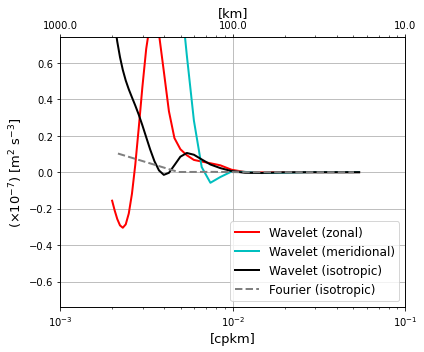

In [27]:
for reg in range(len(xs)-5):
    
    dsw = xr.open_zarr(op.join(savedir,'Wavelet_AdvKETrans_region%02d_1967-01-03_08.zarr' 
                               % reg))
    piw = ((dsw.App + dsw.Au + dsw.Aw + dsw.MtE) 
           * np.abs(np.diff(dsw.scale**-1)[0])).isel(time=0).cumsum('scale').compute()
    dsf = xr.open_zarr(op.join(savedir,'Fourier_AdvKETrans_region%02d_1967-01-03_08.zarr' 
                               % reg))
    pif = ((dsf.App + dsf.Au + dsf.Aw + dsf.MtE) 
           * np.abs(np.diff(dsf.freq_r)[0])
          ).isel(time=0)[...,::-1].cumsum('freq_r')[...,::-1].compute()
        
    fig, ax = plt.subplots(figsize=(6,5))
    fig.set_tight_layout(True)
#             ax2 = ax.twinx()
    ax3 = ax.twiny()
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    ax.plot((dsw.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e7,
            'r', lw=2, label=r"Wavelet (zonal)")
    ax.plot((dsw.scale)**-1*1e3, piw.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e7,
            'c', lw=2, label=r"Wavelet (meridional)")
    ax.plot((dsw.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e7,
            'k', lw=2, label=r"Wavelet (isotropic)")
    ax.plot((dsf.freq_r)*1e3, pif.isel(Z=0).mean(['nmemb'])*1e7,
            c='grey', ls='--', lw=2, label=r"Fourier (isotropic)")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
#             ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    if reg < 5:
        ax.set_ylim([-np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e7*.8),
                     np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e7*.8)])
    else:
        ax.set_ylim([-np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e7*.8,
                     np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e7*.8])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
    if reg == 0:
        ax.legend(loc='lower right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/WvsF_KE-specflux_Region%02d.pdf' % reg))
    plt.show()

# Fourier

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 18)>
array([[[ 1.19575162e-07, -2.12847382e-08,  2.34135466e-09, ...,
          6.33509646e-12,  2.60210275e-12,  9.04652534e-13],
        [ 5.18971286e-08, -1.47464435e-08,  1.84297376e-09, ...,
          2.49597773e-13,  6.39493911e-14,  6.05550600e-15],
        [ 6.81340900e-10,  7.82786247e-11,  2.70492718e-11, ...,
         -1.63678462e-15, -1.13043719e-15, -4.81717679e-16]],

       [[-1.29395987e-09,  9.09115491e-09, -7.22411235e-10, ...,
          9.37701422e-12,  5.18848162e-12,  2.33105642e-12],
        [-2.80953813e-09,  4.00976343e-09, -4.19129161e-10, ...,
          3.50182790e-13,  1.70752892e-13,  7.72312646e-14],
        [ 2.34902499e-10,  1.04695734e-10, -2.51179799e-11, ...,
         -5.58440616e-16, -3.99430598e-16, -1.71877505e-16]],

       [[ 2.13667845e-08, -7.09564226e-10, -4.34222886e-09, ...,
          7.77418264e-12,  3.59980000e-12,  1.32918266e-12],
        [ 5.16284164e-09,  2.06036551e-09,  1.12623748e-11, ...,


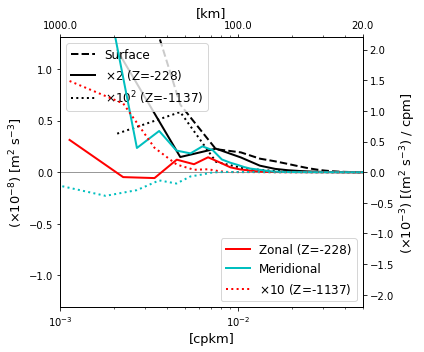

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 17)>
array([[[-5.20486539e-09, -4.52155537e-09,  2.26855224e-10, ...,
          1.09535150e-12,  5.31513543e-13,  1.98093842e-13],
        [-6.55485324e-09, -5.05950051e-09,  3.86176135e-10, ...,
          1.12276389e-13,  3.28552494e-14,  8.18371557e-15],
        [-4.22214705e-10, -2.31731558e-10, -4.28436458e-11, ...,
          1.99980757e-16, -4.28473480e-18, -1.10574864e-16]],

       [[ 1.21755652e-08,  8.39345835e-09,  4.81653571e-09, ...,
          1.09075280e-13,  2.00821597e-15,  1.37443223e-14],
        [ 1.20938560e-09,  2.50013186e-09,  8.07093127e-10, ...,
          7.41159463e-14,  2.96451951e-14,  1.41914126e-14],
        [-2.47209614e-11,  1.98289151e-11, -2.14953742e-11, ...,
          1.17557423e-15,  3.91245084e-16,  1.80764616e-16]],

       [[-1.27743488e-09, -1.05448462e-08, -4.44429522e-09, ...,
          3.72835998e-11,  1.69376785e-11,  5.64169961e-12],
        [ 1.39894665e-09, -2.33024484e-09, -1.27171165e-09, ...,


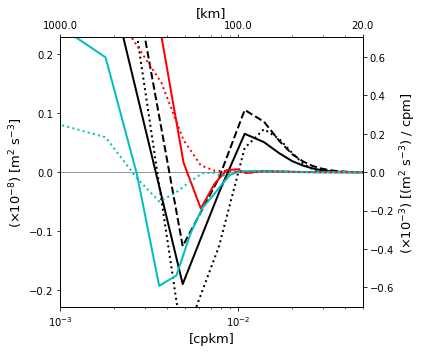

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 19)>
array([[[-7.19141510e-09, -1.33199897e-09,  2.43584575e-10, ...,
          2.86049404e-12,  2.01776652e-12,  1.08760441e-12],
        [-5.80810399e-09, -1.27090469e-09,  8.06388788e-11, ...,
          8.90084137e-13,  5.89661686e-13,  2.87832813e-13],
        [-1.58373312e-11, -1.62109094e-11, -3.25851928e-12, ...,
          6.91010466e-15,  4.81438806e-15,  2.42214635e-15]],

       [[ 1.47243624e-09,  8.50245382e-10,  3.62300095e-11, ...,
          1.44915074e-12,  7.51209249e-13,  2.90455896e-13],
        [-1.07880491e-10, -9.37019295e-11, -1.22457602e-10, ...,
          2.72825692e-13,  1.60718597e-13,  6.35969239e-14],
        [ 5.10162060e-12, -2.19289912e-12,  1.17249120e-12, ...,
          2.40185738e-15,  1.74606152e-15,  7.84321567e-16]],

       [[-1.59477561e-09, -2.77159218e-10, -2.94000702e-11, ...,
          2.32734361e-12,  1.55709146e-12,  7.74123313e-13],
        [-1.79084601e-09, -5.19764451e-10, -3.56197418e-11, ...,


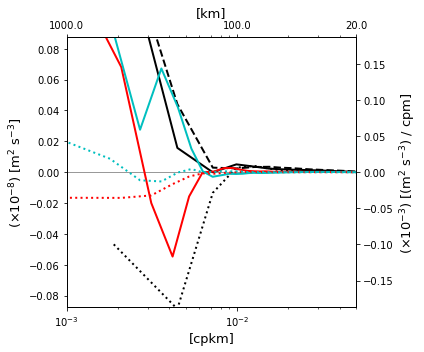

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 19)>
array([[[ 2.24213767e-10, -2.24028923e-11,  4.31485753e-12, ...,
          1.80604367e-16,  2.15903872e-17,  5.30541854e-17],
        [ 1.23248605e-10, -1.88796090e-11, -3.26159088e-12, ...,
          1.46675347e-17,  5.12403405e-18,  4.95447769e-18],
        [ 1.06837242e-12, -1.70645331e-12,  3.98878783e-13, ...,
         -6.56745864e-19, -8.17620725e-19, -5.33777515e-19]],

       [[ 1.57251243e-11, -2.70415977e-11,  1.06938352e-11, ...,
          5.64006916e-16,  2.27272545e-16,  6.71470557e-17],
        [ 3.06861601e-11,  6.23123437e-12, -2.38804366e-12, ...,
          1.49974032e-17,  5.48310914e-18,  6.45271448e-19],
        [-1.92518333e-12, -5.67635190e-13, -2.70970792e-13, ...,
          3.46870591e-19, -1.57595012e-20,  7.86998268e-20]],

       [[ 1.82911473e-10,  1.07986509e-10, -1.39763654e-11, ...,
          4.86135813e-16,  1.45730888e-16,  8.79463266e-18],
        [-8.96542754e-11, -5.32158950e-11, -6.87338944e-12, ...,


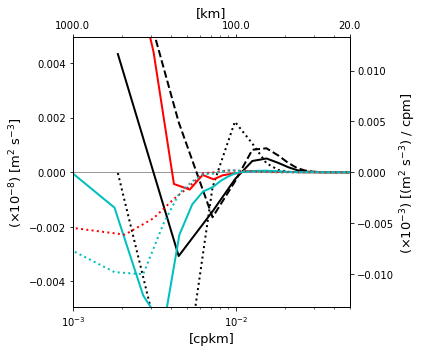

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 20)>
array([[[ 4.57964606e-10,  2.56562725e-12, -9.81113087e-11, ...,
          6.42701356e-15,  3.04624463e-15,  1.39845765e-15],
        [ 2.52761991e-10, -1.86449434e-11, -5.69363926e-11, ...,
          2.54099206e-16,  9.13050915e-17,  2.79279490e-17],
        [-9.45724936e-12,  1.14604500e-12,  1.72601622e-13, ...,
         -3.82952820e-20,  2.48429027e-20,  2.47613342e-20]],

       [[ 1.06103430e-09,  4.62972134e-10,  2.08641758e-11, ...,
          3.16122875e-14,  1.47236233e-14,  4.92861693e-15],
        [ 2.38689121e-10, -1.96996312e-11,  8.52359256e-12, ...,
          2.57441321e-17,  9.99120995e-18,  2.83654585e-18],
        [ 2.85660474e-11,  4.34263486e-12, -7.25564545e-13, ...,
          7.11414330e-19,  3.02152877e-19,  5.37677987e-20]],

       [[ 2.49342769e-10,  8.30762612e-11,  2.75294079e-11, ...,
          2.16434025e-15,  8.24143745e-16,  3.18780582e-16],
        [ 7.51497401e-11,  1.45470894e-11,  1.79871481e-12, ...,


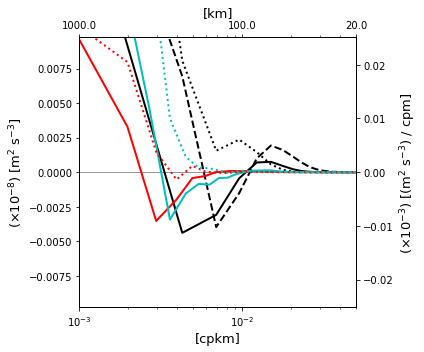

<xarray.DataArray (nmemb: 48, Z: 3, freq_r: 20)>
array([[[ 5.82313439e-11, -5.98379538e-11, -7.53119587e-12, ...,
          5.13588284e-16,  1.52577779e-16,  4.67980449e-17],
        [ 2.42076210e-11, -1.91216390e-11, -1.07056725e-11, ...,
          2.16304173e-18,  3.81470040e-19,  1.56988084e-19],
        [ 1.25689679e-11,  2.83075660e-13,  5.55750038e-13, ...,
          1.78611811e-20, -4.05389542e-20,  3.07077808e-20]],

       [[ 1.30892897e-10, -8.75710521e-11, -3.41827830e-11, ...,
         -2.04841513e-16, -1.07085706e-16, -5.91199838e-17],
        [-1.22885189e-11, -3.93195562e-12, -2.99151152e-12, ...,
          3.26047988e-18,  1.50654726e-18,  6.05557067e-19],
        [ 2.28629955e-12,  1.84989713e-12, -1.29129458e-14, ...,
          4.18300437e-20,  3.94217702e-20,  5.23829710e-21]],

       [[-6.98019873e-11, -6.18991841e-11,  1.01597097e-12, ...,
          2.95982601e-16,  2.30958339e-16,  9.60889075e-17],
        [-3.00552821e-14, -2.60745819e-11,  6.82021282e-12, ...,


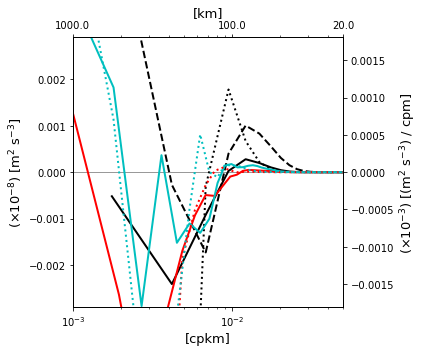

In [7]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                          XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                          XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                              XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                              XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         YG=slice(ys[reg]-5-12**-1,ys[reg]+5+12**-1),
                                                         XC=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1),
                                                         XG=slice(xs[reg]-5-12**-1,xs[reg]+5+12**-1)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])
            
            Au = ((grid.interp(ds.UVEL.where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[0,14,24])
                   * grid.diff((ds.UVEL*ds.dyG).where(ds.maskW!=0.),'X',boundary='extend').isel(Z=[0,14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.) 
                                 * grid.interp(grid.diff((ds.UVEL*ds.dxC).where(ds.maskW!=0.),
                                                         'Y',boundary='extend'),
                                               'X',boundary='extend'),
                                 'Y',boundary='extend').isel(Z=[0,14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)
                                 ).reset_coords(drop=True).interpolate_na(dim='XC'
                                                                         ).interpolate_na(dim='YC'
                                                                                         ).fillna(0.)
            Av = ((grid.interp(ds.UVEL.where(ds.maskW!=0.) 
                               * grid.interp(grid.diff((ds.VVEL*ds.dyC).where(ds.maskS!=0.),
                                                       'X',boundary='extend'),
                                             'Y',boundary='extend'),
                               'X',boundary='extend').isel(Z=[0,14,24])
                   + grid.interp(ds.VVEL.where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[0,14,24])
                   * grid.diff((ds.VVEL*ds.dxG).where(ds.maskS!=0.),'Y',boundary='extend').isel(Z=[0,14,24])
                  ) / ds.rA).isel(YC=slice(1,-1),XC=slice(1,-1)
                                 ).reset_coords(drop=True).interpolate_na(dim='YC'
                                                                         ).interpolate_na(dim='XC'
                                                                                         ).fillna(0.)
#             print(Au,Av)
            
#             fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
#             Au.isel(nmemb=0).plot(ax=ax1)
#             Av.isel(nmemb=0).plot(ax=ax2)
            
            up = grid.interp((ds.UVEL - dsb.UVEL).where(ds.maskW!=0.),
                             'X',boundary='extend'
                            ).isel(Z=[0,14,24],YC=slice(1,-1),XC=slice(1,-1)
                                  ).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='XC'
                                                                           ).interpolate_na(dim='YC'
                                                                                           ).fillna(0.)
            vp = grid.interp((ds.VVEL - dsb.VVEL).where(ds.maskS!=0.),
                             'Y',boundary='extend'
                            ).isel(Z=[0,14,24],YC=slice(1,-1),XC=slice(1,-1)
                                  ).chunk({'YC':-1,'XC':-1}).interpolate_na(dim='YC'
                                                                           ).interpolate_na(dim='XC'
                                                                                           ).fillna(0.)
            Aup = (Au - Au.mean('nmemb',skipna=True)
                  ).chunk({'YC':-1,'XC':-1})
            Avp = (Av - Av.mean('nmemb',skipna=True)
                  ).chunk({'YC':-1,'XC':-1})

            dx = grid.interp(ds.dxC,'X',boundary='extend').mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').mean(skipna=True)
            N = up.shape
            up = xr.DataArray(up.data, dims=up.dims, 
                              coords={'nmemb':up.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            vp = xr.DataArray(vp.data, dims=vp.dims, 
                              coords={'nmemb':vp.nmemb,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            Aup = xr.DataArray(Aup.data, dims=Aup.dims, 
                               coords={'nmemb':Aup.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            Avp = xr.DataArray(Avp.data, dims=Avp.dims, 
                               coords={'nmemb':Avp.nmemb,
                                       'YC':np.arange(0,N[-2]*dy,dy),
                                       'XC':np.arange(0,N[-1]*dx,dx)}
                              )
            
            ntheta=36
            csUA = xrft.cross_spectrum(
                    up, Aup, dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
            )
            csVA = xrft.cross_spectrum(
                    vp, Avp, dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
            )
            
            cs = (csUA+csVA).real
            pil_0 = -(cs.sel(freq_YC=0).isel(freq_XC=slice(int(N[-1]/2)+1,None))*np.diff(cs.freq_XC)[0]
                     )[...,::-1].cumsum('freq_XC')[...,::-1].compute()
            pik_0 = -(cs.sel(freq_XC=0).isel(freq_YC=slice(int(N[-2]/2)+1,None))*np.diff(cs.freq_YC)[0]
                     )[...,::-1].cumsum('freq_YC')[...,::-1].compute()
            
            iso_cs = xrft.isotropize(cs, ["freq_YC","freq_XC"], truncate=True)
            pi = -(iso_cs*np.diff(iso_cs.freq_r)[0]
                  )[...,::-1].cumsum('freq_r')[...,::-1].compute()
#             pi = -(iso_cs*np.diff(iso_cs.freq_r)[0]).cumsum('freq_r')
            print(pi)
                  
            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
            ax2 = ax.twinx()
            ax3 = ax.twiny()
            ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), c='grey', alpha=.8, lw=1)
            ax2.plot(pil_0.freq_XC*1e3, pil_0.isel(Z=1).mean(['nmemb'])*1e3,
                     'r', lw=2, label=r"Zonal (Z=-228)")
            ax2.plot(pik_0.freq_YC*1e3, pik_0.isel(Z=1).mean(['nmemb'])*1e3,
                     'c', lw=2, label=r"Meridional")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=0).mean(['nmemb'])*1e8,
                    'k--', lw=2, label=r"Surface")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=1).mean(['nmemb'])*2e8,
                    'k', lw=2, label=r"$\times 2$ (Z=-228)")
            ax.plot(pi.freq_r*1e3, pi.isel(Z=2).mean(['nmemb'])*1e10,
                    'k:', lw=2, label=r"$\times 10^{2}$ (Z=-1137)")
            ax2.plot(pil_0.freq_XC*1e3, pil_0.isel(Z=2).mean(['nmemb'])*1e4,
                     'r:', lw=2, label=r"$\times 10$ (Z=-1137)")
            ax2.plot(pik_0.freq_YC*1e3, pik_0.isel(Z=2).mean(['nmemb'])*1e4,
                     'c:', lw=2)
            ax.set_xscale('log')
#             ax.set_yscale('log')
#             ax2.set_xscale('log')
            ax3.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax.set_ylim([-np.abs(pi.isel(Z=0).mean(['nmemb'])).max()*1e8*.5,
                         np.abs(pi.isel(Z=0).mean(['nmemb'])).max()*1e8*.5])
            Mpi = np.fmax(np.abs(pik_0.isel(Z=1).mean(['nmemb'])).max()*1e3,
                          np.abs(pil_0.isel(Z=1).mean(['nmemb'])).max()*1e3)
            ax2.set_ylim([-.5*Mpi, .5*Mpi])
            ax3.set_xlim([1e-3,5e-2])
            ax3.set_xticks([1e-3,1e-2,5e-2])
            ax3.set_xticklabels([1e3,1e2,2e1])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax3.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
            ax2.set_ylabel(r"($\times 10^{-3}$) [(m$^2$ s$^{-3}$) / cpm]", fontsize=13)
#             ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
            if reg == 0:
                ax.legend(loc='upper left', fontsize=12)
                ax2.legend(loc='lower right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
            
            plt.savefig(op.join(savedir,'Figs/KE-Fourierspecflux_Region%02d.pdf' 
                                % reg))
            plt.show()

In [19]:
da = xr.DataArray(np.arange(10), dims='x', coords={'x':range(10)})
print(da.cumsum('x'))
print(da[::-1].cumsum('x')[::-1])

<xarray.DataArray (x: 10)>
array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
<xarray.DataArray (x: 10)>
array([45, 45, 44, 42, 39, 35, 30, 24, 17,  9])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
